## Exercise 1: Predicting the Temperature

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn import linear_model
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [2]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
weather_df.describe()

,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure
count,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.000000,96453.0,96453.000000
mean,11.932678,10.855029,0.734899,10.810640,187.509232,10.347325,0.0,1003.235956
std,9.551546,10.696847,0.195473,6.913571,107.383428,4.192123,0.0,116.969906
min,-21.822222,-27.716667,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.688889,2.311111,0.600000,5.828200,116.000000,8.339800,0.0,1011.900000
50%,12.000000,12.000000,0.780000,9.965900,180.000000,10.046400,0.0,1016.450000
75%,18.838889,18.838889,0.890000,14.135800,290.000000,14.812000,0.0,1021.090000
max,39.905556,39.344444,1.000000,63.852600,359.000000,16.100000,0.0,1046.380000


In [4]:
weather_df.describe(include="O")

,summary,preciptype,dailysummary
count,96453,96453,96453
unique,27,3,214
top,Partly Cloudy,rain,Mostly cloudy throughout the day.
freq,31733,85224,20085


In [5]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [6]:
# We need to convert categorical non-numerical columns into numerical columns
non_numeric_columns = weather_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['summary', 'preciptype', 'dailysummary'], dtype='object')
The number of non-numerical columns is 3


In [7]:
# Count number of numerical columns as well
numeric_columns = weather_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['temperature', 'apparenttemperature', 'humidity', 'windspeed',
       'windbearing', 'visibility', 'loudcover', 'pressure'],
      dtype='object')
The number of numerical columns is 8


There are no missing values!

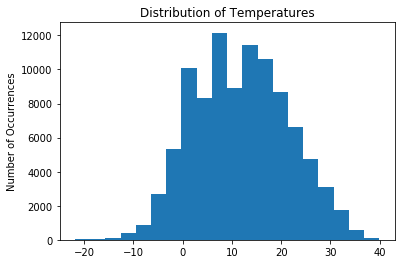

In [8]:
# Plot distribution for target variable
plt.hist(weather_df.temperature, bins=20)
plt.title("Distribution of Temperatures")
plt.ylabel("Number of Occurrences")
plt.show()

We observe that the temperatures are normally distributed, possible slightly skewed to the right.

In [9]:
# Correlations of the features (aboslute value) with our target variable 
np.abs(weather_df[numeric_columns].iloc[:,1:].corr().loc[:,'temperature']).sort_values(ascending=False)

KeyError: 'temperature'

In [ ]:
# Plot each feature against the target variable to understand the univariate relation between the target variable
# and non-numerical features

# Shown below are the average temperatures with respect to the each category of a feature

plt.figure(figsize=(40,60))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(3,1,index+1)
    plt.bar(weather_df.groupby(column)["temperature"].mean().index, weather_df.groupby(column)["temperature"].mean(),
           color=("red","blue"))
    plt.title("Avg temperature with respect to {}".format(column))
    plt.ylabel("Avg temperature")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [11]:
# Convert chosen variables to dummy variables so we can use in our model
weather_df = pd.concat([weather_df,pd.get_dummies(weather_df.preciptype, prefix="preciptype", drop_first=True)], axis=1)
weather_df = pd.concat([weather_df,pd.get_dummies(weather_df.summary, prefix="summary", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(weather_df.preciptype, prefix="preciptype", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(weather_df.summary, prefix="summary", drop_first=True).columns)

## The Model

In [12]:
X = weather_df[['humidity','windspeed', 'windbearing', 'pressure'] + dummy_column_names]
Y = weather_df.temperature

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     4744.
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        19:57:08   Log-Likelihood:            -3.0892e+05
No. Observations:               96453   AIC:                         6.179e+05
Df Residuals:                   96420   BIC:                         6.182e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          31.3682      0.871     35.995      0.000      29.660      33.076
humidity                                      -25.8516      0.116   -223.673      0.000     -26.078     -25.625
windspeed                                      -0.1987      0.003    -59.657      0.000      -0.205      -0.192
windbearing                                     0.0021      0.000     11.738      0.000       0.002       0.002
pressure                                       -0.0009      0.000     -5.191      0.000      -0.001      -0.001
preciptype_rain                                 2.3202      0.263      8.824      0.000       1.805       2.836
preciptype_snow                               -10.7046      0.269    -39.800      0.000     -11.232     -10.177
summary_Breezy and Dry                          1.2428      6.009      0.207      0.836     -10.535      13.021
summary_Breezy and Foggy                        7.3021      1.295      5.638      0.000       4.764       9.840
summary_Breezy and Mostly Cloudy                1.5526      0.855      1.816      0.069      -0.123       3.228
summary_Breezy and Overcast                     1.6474      0.854      1.929      0.054      -0.027       3.321
summary_Breezy and Partly Cloudy                0.1314      0.868      0.151      0.880      -1.570       1.833
summary_Clear                                   0.8592      0.818      1.050      0.294      -0.744       2.463
summary_Dangerously Windy and Partly Cloudy     0.8387      6.010      0.140      0.889     -10.941      12.619
summary_Drizzle                                 2.1625      1.255      1.723      0.085      -0.298       4.623
summary_Dry                                     4.6692      1.308      3.569      0.000       2.105       7.233
summary_Dry and Mostly Cloudy                   2.6110      1.789      1.459      0.144      -0.896       6.118
summary_Dry and Partly Cloudy                   1.9976      1.040      1.921      0.055      -0.041       4.036
summary_Foggy                                  -0.2574      0.820     -0.314      0.754      -1.865       1.350
summary_Humid and Mostly Cloudy                12.3538      1.246      9.913      0.000       9.911      14.796
summary_Humid and Overcast                     13.1370      2.394      5.487      0.000       8.445      17.829
summary_Humid and Partly Cloudy                12.2517      1.659      7.385      0.000       9.000      15.503
summary_Light Rain                              2.7043      1.108      2.440      0.015       0.532       4.876
summary_Mostly Cloudy                           1.3161      0.817      1.611      0.107      -0.285       2.917
summary_Overcast                                0.3998     

## Assumption one: linearity of the model in its coefficients
The target variable should be a linear function of the model's coefficients

In [13]:
# Y is the target variable
Y = weather_df['temperature']

# X is the feature set
X = weather_df[['humidity','windspeed', 'windbearing', 'pressure']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

predictions = lrm.predict(X)
errors = np.array(Y) - predictions

# Estimated coefficients.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.926438185285306


## Assumption two: the error term should be zero on average¶
This second assumption states that the expected value of the error term should be zero.

In [15]:
print("Mean of the errors in the temperature model is: {}".format(np.mean(errors)))
print('This number is essentially zero, so assumption 2 is met.')

Mean of the errors in the temperature model is: -7.449232417867907e-16
This number is essentially zero, so assumption 2 is met.


## Assumption three: homoscedasticity
A model is homoscedastic when the distribution of its error terms (known as "scedasticity") is consistent for all predicted values. This means that the error variance shouldn't systematically change across observations. When this assumption is not met, we are dealing with heteroscedasticity.

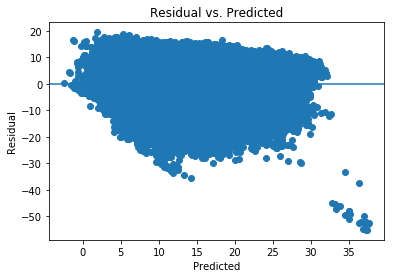

In [16]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

This plot of the predictions vs errors does not imply homoscedasticity.

In [17]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic. So both our tests show the model is heteroscedastic, meaning that the accuracy of our estimations are not very reliable and condition 3 is not met.

## Assumption four: low multicollinearity
Individual features should be only weakly correlated with one another, and ideally completely uncorrelated. When features are correlated, they may both explain the same pattern of variance in the outcome. The model will attempt to find a solution, potentially by attributing half the explanatory power to one feature and half to the other. Multicollinearity can cause us to underestimate the relationship between features and outcomes, which can be harmful if we want to know which features matter most when predicting an outcome.

In [18]:
X.corr()

,humidity,windspeed,windbearing,pressure
humidity,1.000000,-0.224951,0.000735,0.005454
windspeed,-0.224951,1.000000,0.103822,-0.049263
windbearing,0.000735,0.103822,1.000000,-0.011651
pressure,0.005454,-0.049263,-0.011651,1.000000


No highly correlated features here! Assumption 4 is met.

## Assumption five: error terms should be uncorrelated with one another
The error term for one observation shouldn't predict the error term for another. This type of serial correlation may happen if we omit a relevant variable from the model.

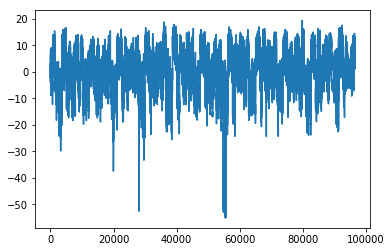

In [19]:
plt.plot(errors)
plt.show()

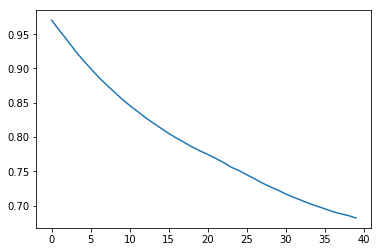

In [20]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The errors appear to be serially correlated. This is because of the time series nature of the data. The weather from the previous day is highly correlated with the weather today. Our model can't explain the temperature very well and hence it suffers from the omitted variable. However, since the dataset involves very limited number of features, fixing this issue is not trivial.

## Assumption six: features shouldn't be correlated with the errors
Explanatory variables and errors should be independent. If this assumption doesn't hold, then the model's predictions will be unreliable as the estimates of the coefficients would be biased. This assumption is known as the exogeneity. Common causes of exogeneity violations are omitted variables and simultaneous causation between independent variables and the target.

In [21]:
df = pd.concat([X, pd.DataFrame(errors, columns=["error"])], axis=1)
df.corr().iloc[:,-1:]

,error
humidity,-1.270920e-15
windspeed,1.124096e-15
windbearing,-8.232541e-17
pressure,-1.657974e-15
error,1.000000e+00


The table above shows that the features and errors are not correlated, i.e. independent. Condition 6 is met.

## A very important remark on the normality of the errors
This is not an assumption of OLS, but it still can impact our results. Normality of errors is not required to apply OLS to a linear regression model, but in order to measure the statistical significance of our estimated coefficients, error terms must be normally distributed.

Non-normally distributed errors usually stem from omitted variables. Including the omitted relevant features to the model may help fix the issue. Sometimes, transforming the dependent variable also helps.

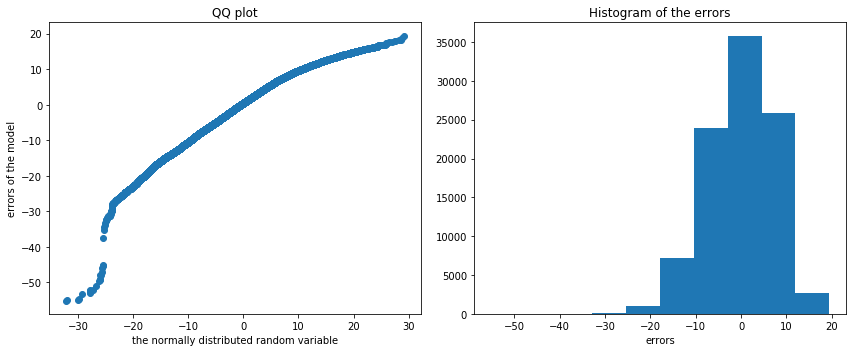

In [22]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [23]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.2967352523665 and p value is 0.0
Normality test statistics is 3375.432307699586 and p value is 0.0


These normality tests and graphs shown above indicate that the errors of the model are not distributed normally. This means that the test statistics for the coefficients are problematic.